# AON ROI Signal Extraction

Author: Olaf Borghi olafborghi@gmail.com

In this script I will extract the signal from each action observation & feature processing ROI mask that I created in the two previous scripts. 

Some code was taken/adapted from https://github.com/lrsktr/tewa-neuroimaging/blob/main/08_masking-and-extracting-signals/08_masking-extracting-signals.ipynb

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [1]:
# Import packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype.interfaces import fsl
from nilearn import plotting, datasets, image
from nilearn.image import math_img
from nilearn.maskers import NiftiLabelsMasker
from pathlib import Path
from pprint import pprint
from glob import glob
print(nl.__version__)

0.9.2


**Set fixed parameters**

In [2]:
# fixed folders

basedir = Path("/home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/")

outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"
masks_templates_dir = outputdir / "masks_templates"
second_level_dir = outputdir / "second_level"
AON_second_level_dir = second_level_dir / "AON-task"
action_second_level_dir = second_level_dir / "action-task"
atlas_dir = outputdir / "brain_atlases"
roi_dir = masks_templates_dir / "ROI_masks"

# load the MNI template
template = datasets.load_mni152_template(resolution=1)

### Load the ROI masks

In [3]:
# store the paths of the anat_roi * AON_Action_conjunction masks
left_ipl_path = roi_dir / "left_ipl_aon_mask.nii.gz"
right_ipl_path = roi_dir / "right_ipl_aon_mask.nii.gz"
left_ifg_path = roi_dir / "left_ifg_aon_mask.nii.gz"
right_ifg_path = roi_dir / "right_ifg_aon_mask.nii.gz"
left_pm_path = roi_dir / "left_pm_aon_mask.nii.gz"
right_pm_path = roi_dir / "right_pm_aon_mask.nii.gz"
left_m1_path = roi_dir / "left_m1_aon_mask.nii.gz"
left_s1_path = roi_dir / "left_s1_aon_mask.nii.gz"
right_s1_path = roi_dir / "right_s1_aon_mask.nii.gz"
left_s2_path = roi_dir / "left_s2_aon_mask.nii.gz"
right_s2_path = roi_dir / "right_s2_aon_mask.nii.gz"

# store the paths of the anat_roi * Face_Body_combined masks
left_loc_path = roi_dir / "left_loc_fb_mask.nii.gz"
right_loc_path = roi_dir / "right_loc_fb_mask.nii.gz"
left_fc_path = roi_dir / "left_fusiform_cortex_fb_mask.nii.gz"
right_fc_path = roi_dir / "right_fusiform_cortex_fb_mask.nii.gz"
left_v5_path = roi_dir / "left_V5_fb_mask.nii.gz"
right_v5_path = roi_dir / "right_V5_fb_mask.nii.gz"
left_pSTS_path = roi_dir / "left_pSTS_fb_mask.nii.gz"
right_pSTS_path = roi_dir / "right_pSTS_fb_mask.nii.gz"

# load the anat_roi * AON_Action_conjunction masks
left_ipl = nib.load(left_ipl_path)
right_ipl = nib.load(right_ipl_path)
left_ifg = nib.load(left_ifg_path)
right_ifg = nib.load(right_ifg_path)
left_pm = nib.load(left_pm_path)
right_pm = nib.load(right_pm_path)
left_m1 = nib.load(left_m1_path)
left_s1 = nib.load(left_s1_path)
right_s1 = nib.load(right_s1_path)
left_s2 = nib.load(left_s2_path)
right_s2 = nib.load(right_s2_path)

# load the anat_roi * Face_Body_combined masks
left_loc = nib.load(left_loc_path)
right_loc = nib.load(right_loc_path)
left_fusiform = nib.load(left_fc_path)
right_fusiform = nib.load(right_fc_path)
left_v5 = nib.load(left_v5_path)
right_v5 = nib.load(right_v5_path)
left_pSTS = nib.load(left_pSTS_path)
right_pSTS = nib.load(right_pSTS_path)

# store the anat_roi * AON_Action_conjunction masks in a list
aon_roi_masks = [left_ipl, right_ipl, left_ifg, right_ifg, left_pm, right_pm, left_m1, left_s1, right_s1]

# store the anat_roi * Face_Body_combined masks in a list
fb_roi_masks = [left_loc, right_loc, left_fusiform, right_fusiform, left_v5, right_v5, left_pSTS, right_pSTS]

# make a list that includes all masks
roi_masks = aon_roi_masks + fb_roi_masks

Plot the roi masks once more just as a sanity check

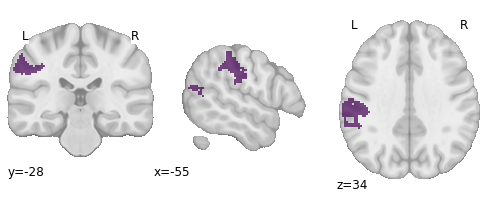

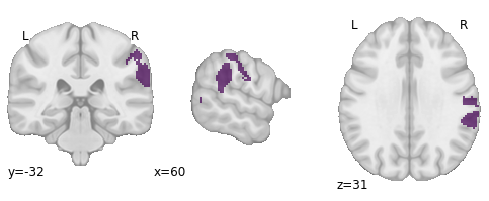

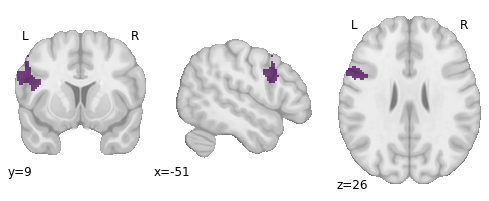

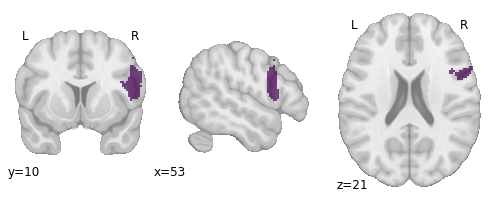

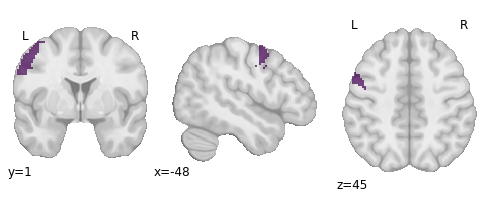

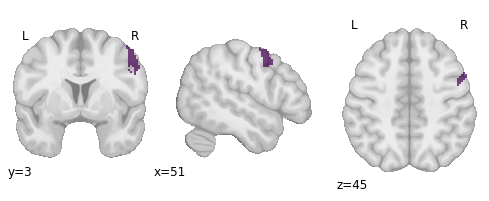

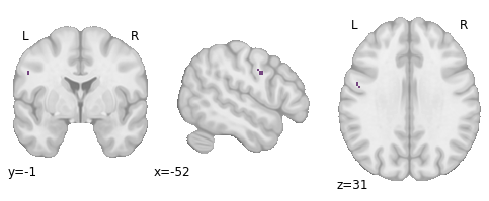

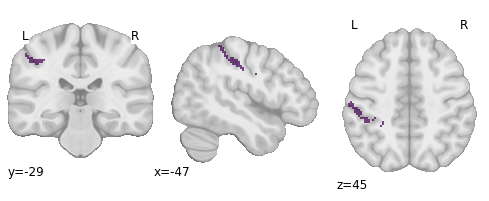

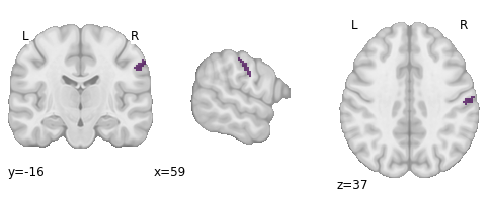

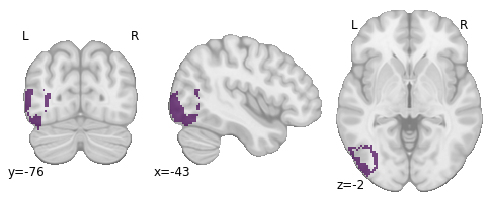

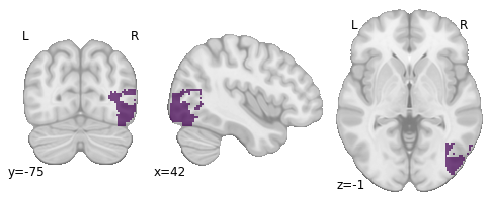

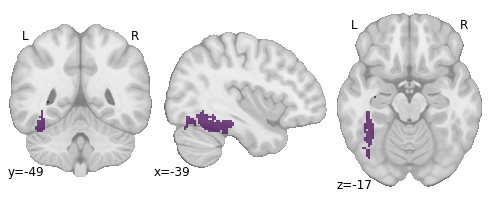

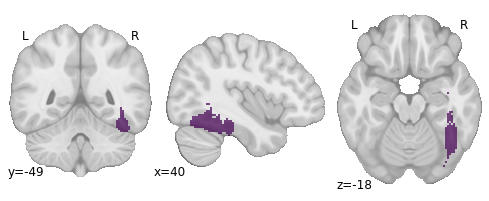

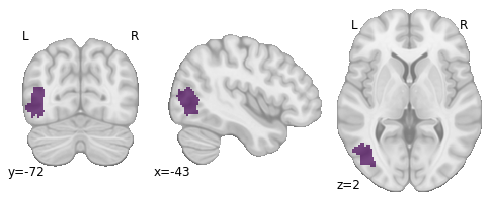

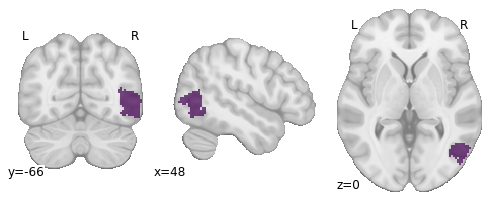

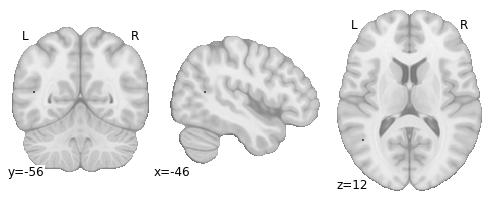

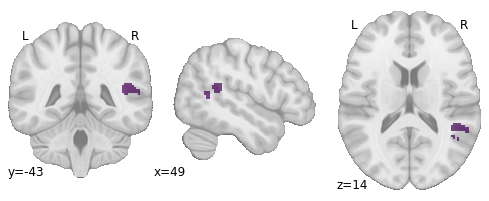

In [4]:
for roi in roi_masks:
    plotting.plot_roi(roi, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)

### Load the first level contrasts

In [5]:
# contrasts of interest
# human transitive - baseline
cmaps_transitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_transitive-baseline/*.nii.gz",
         recursive=True)
)

# human intransitive - baseline
cmaps_intransitive_baseline_human = sorted(
    glob(f"{AON_first_level_dir}/human_intransitive-baseline/*.nii.gz",
         recursive=True)
)

# dog transitive - baseline
cmaps_transitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_transitive-baseline/*.nii.gz",
         recursive=True)
)

# dog intransitive - baseline
cmaps_intransitive_baseline_dog = sorted(
    glob(f"{AON_first_level_dir}/dog_intransitive-baseline/*.nii.gz",
         recursive=True)
)

## Extract the signal from each region

I start by defining a function that makes it easier to extract the signal later on.

In [6]:
def extract_roi(cmaps, mask):
  '''extract mean roi activation from contrast map
    
     Input: 
     - List of contract maps 
     - ROI mask

    Output: Time series
  '''

  # instantiate numpy array to store results
  out = np.zeros(len(cmaps))

  # setup masker
  masker = NiftiLabelsMasker(mask)

  # loop over subjects
  print("Start extracting mean signal for each contrast map")
  for i, cmap in enumerate(cmaps):
    time_series = masker.fit_transform(cmap)
    out[i] = np.mean(time_series)
  print("Done extracting mean signal for each contrast map")
    
  return out

Extract the signal from each region in each of the conditions using this function

**Human transitive vs. baseline**

In [7]:
## Action processing regions

# inferior parietal lobule
left_ipl_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_ipl)
right_ipl_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_ipl)

# inferior frontal gyrus
left_ifg_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_ifg)
right_ifg_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_ifg)

# premotor cortex
left_pm_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_pm)
right_pm_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_pm)

# primary motor cortex
left_m1_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_m1)

# primary somatosensory cortex
left_s1_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_s1)
right_s1_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_s1)

# secondary somatosensory cortex
left_s2_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_s2)
right_s2_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_s2)


## Feature processing regions

# lateral occipital cortex
left_loc_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_loc)
right_loc_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_loc)

# fusiform cortex
left_fusiform_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_fusiform)
right_fusiform_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_fusiform)

# area V5
left_v5_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_v5)
right_v5_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_v5)

# posterior superior temporal sulcus
left_pSTS_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, left_pSTS)
right_pSTS_transitive_human_signal = extract_roi(cmaps_transitive_baseline_human, right_pSTS)

Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each con

**Human intransitive vs. baseline**

In [8]:
## Action processing regions

# inferior parietal lobule
left_ipl_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_ipl)
right_ipl_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_ipl)

# inferior frontal gyrus
left_ifg_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_ifg)
right_ifg_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_ifg)

# premotor cortex
left_pm_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_pm)
right_pm_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_pm)

# primary motor cortex
left_m1_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_m1)

# primary somatosensory cortex
left_s1_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_s1)
right_s1_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_s1)

# secondary somatosensory cortex
left_s2_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_s2)
right_s2_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_s2)


## Feature processing regions

# lateral occipital cortex
left_loc_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_loc)
right_loc_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_loc)

# fusiform cortex
left_fusiform_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_fusiform)
right_fusiform_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_fusiform)

# area V5
left_v5_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_v5)
right_v5_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_v5)

# posterior superior temporal sulcus
left_pSTS_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, left_pSTS)
right_pSTS_intransitive_human_signal = extract_roi(cmaps_intransitive_baseline_human, right_pSTS)

Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each con

**Dog transitive vs baseline**

In [9]:
## Action processing regions

# inferior parietal lobule
left_ipl_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_ipl)
right_ipl_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_ipl)

# inferior frontal gyrus
left_ifg_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_ifg)
right_ifg_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_ifg)

# premotor cortex
left_pm_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_pm)
right_pm_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_pm)

# primary motor cortex
left_m1_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_m1)

# primary somatosensory cortex
left_s1_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_s1)
right_s1_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_s1)

# secondary somatosensory cortex
left_s2_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_s2)
right_s2_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_s2)


## Feature processing regions

# lateral occipital cortex
left_loc_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_loc)
right_loc_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_loc)

# fusiform cortex
left_fusiform_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_fusiform)
right_fusiform_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_fusiform)

# area V5
left_v5_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_v5)
right_v5_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_v5)

# posterior superior temporal sulcus
left_pSTS_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, left_pSTS)
right_pSTS_transitive_dog_signal = extract_roi(cmaps_transitive_baseline_dog, right_pSTS)

Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each con

**Dog intransitive vs. baseline**

In [10]:
## Action processing regions

# inferior parietal lobule
left_ipl_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_ipl)
right_ipl_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_ipl)

# inferior frontal gyrus
left_ifg_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_ifg)
right_ifg_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_ifg)

# premotor cortex
left_pm_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_pm)
right_pm_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_pm)

# primary motor cortex
left_m1_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_m1)

# primary somatosensory cortex
left_s1_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_s1)
right_s1_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_s1)

# secondary somatosensory cortex
left_s2_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_s2)
right_s2_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_s2)


## Feature processing regions

# lateral occipital cortex
left_loc_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_loc)
right_loc_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_loc)

# fusiform cortex
left_fusiform_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_fusiform)
right_fusiform_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_fusiform)

# area V5
left_v5_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_v5)
right_v5_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_v5)

# posterior superior temporal sulcus
left_pSTS_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, left_pSTS)
right_pSTS_intransitive_dog_signal = extract_roi(cmaps_intransitive_baseline_dog, right_pSTS)

Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each contrast map
Start extracting mean signal for each contrast map
Done extracting mean signal for each con

### Create dataframe for analysis

**Load the participants.tsv file**

In [11]:
df_participants = pd.read_table(datadir / "participants.tsv")
df_participants.head(5)

,participant_id,age,sex,dog_expert,handedness,perspective_taking,online_simulation,emotion_contagion,proximal_responsivity,peripheral_responsivity,...,affective_empathy,affection,knowledge,shared_household,shared_household_years,ownership,ownership_count,expertise,expertise_years,expertise_open
0,sub-01,19,0,0,1,3.4,3.111111,3.25,3.50,3.25,...,3.333333,4,3,0,NaN,0,NaN,0,NaN,NaN
1,sub-02,21,1,0,1,2.3,3.333333,2.50,2.00,2.50,...,2.333333,3,2,0,NaN,0,NaN,0,NaN,NaN
2,sub-03,26,1,0,1,4.0,3.888889,2.75,3.00,2.75,...,2.833333,4,3,0,NaN,0,NaN,0,NaN,NaN
3,sub-04,20,0,1,1,3.0,2.777778,2.75,3.25,3.00,...,3.000000,5,4,1,20.0,1,1.0,1,3.0,Hundeschule
4,sub-05,20,0,0,1,3.5,3.333333,3.50,3.00,3.25,...,3.250000,4,3,0,NaN,0,NaN,0,NaN,NaN


I start by defining a function to make my life much easier, note that this function is only suited for this very specific use case here.

In [12]:
def CreateDataFrame(activation, region, region_type, hemisphere, contrast, condition1, condition2):
    ''' helper function to create a Dataframe for this very specific use case '''
    df = pd.DataFrame()
    df['participant_id'] = df_participants['participant_id']
    df['handedness'] = df_participants['handedness']
    df['age'] = df_participants['age']
    df['sex'] = df_participants['sex']
    df['action_factor'] = condition1
    df['agent_factor'] = condition2
    df['observer_factor'] = df_participants['dog_expert']
    df['contrast'] = contrast
    df['region'] = region
    df['region_type'] = region_type
    df['hemisphere'] = hemisphere
    df['activation'] = activation
    df['cognitive_empathy'] = df_participants['cognitive_empathy']
    df['affective_empathy'] = df_participants['affective_empathy']
    df['perspective_taking'] = df_participants['perspective_taking']
    df['online_simulation'] = df_participants['online_simulation']
    df['emotion_contagion'] = df_participants['emotion_contagion']
    df['proximal_responsivity'] = df_participants['proximal_responsivity']
    df['peripheral_responsivity'] = df_participants['peripheral_responsivity']
    df['dog_affection'] = df_participants['affection']
    df['dog_knowledge'] = df_participants['knowledge']
    df['dog_household'] = df_participants['shared_household']
    df['dog_household_years'] = df_participants['shared_household_years']
    df['dog_ownership'] = df_participants['ownership']
    df['dog_ownership_number'] = df_participants['ownership_count']
    df['dog_training_rating'] = df_participants['expertise']
    df['dog_training_years'] = df_participants['expertise_years']
    df['dog_training_open'] = df_participants['expertise_open']
    return df

#### Create pandas dataframe for each region and condition

**Human transitive vs. baseline**

In [13]:
## Action processing regions

# inferior parietal lobule
df_left_ipl_transitive_human = CreateDataFrame(left_ipl_transitive_human_signal, "inferior_parietal_lobule", "action", "left", 
                                               "transitive_baseline_human", "transitive", "human")
df_right_ipl_transitive_human = CreateDataFrame(right_ipl_transitive_human_signal, "inferior_parietal_lobule", "action", "right", 
                                                "transitive_baseline_human", "transitive", "human")

# inferior frontal gyrus
df_left_ifg_transitive_human = CreateDataFrame(left_ifg_transitive_human_signal, "inferior_frontal_gyrus", "action", "left", 
                                               "transitive_baseline_human", "transitive", "human")
df_right_ifg_transitive_human = CreateDataFrame(right_ifg_transitive_human_signal, "inferior_frontal_gyrus", "action", "right", 
                                                "transitive_baseline_human", "transitive", "human")

# premotor cortex
df_left_pm_transitive_human = CreateDataFrame(left_pm_transitive_human_signal, "premotor_cortex", "action", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_pm_transitive_human = CreateDataFrame(right_pm_transitive_human_signal, "premotor_cortex", "action", "right", 
                                               "transitive_baseline_human", "transitive", "human")

# primary motor cortex
df_left_m1_transitive_human = CreateDataFrame(left_m1_transitive_human_signal, "primary_motor_cortex", "action", "left", 
                                              "transitive_baseline_human", "transitive", "human")

# primary somatosensory cortex
df_left_s1_transitive_human = CreateDataFrame(left_s1_transitive_human_signal, "primary_somatosensory_cortex", "action", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_s1_transitive_human = CreateDataFrame(right_s1_transitive_human_signal, "primary_somatosensory_cortex", "action", "right", 
                                               "transitive_baseline_human", "transitive", "human")

# secondary somatosensory cortex
df_left_s2_transitive_human = CreateDataFrame(left_s2_transitive_human_signal, "secondary_somatosensory_cortex", "action", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_s2_transitive_human = CreateDataFrame(right_s2_transitive_human_signal, "secondary_somatosensory_cortex", "action", "right", 
                                               "transitive_baseline_human", "transitive", "human")


## Feature processing regions

# lateral occipital cortex
df_left_loc_transitive_human = CreateDataFrame(left_loc_transitive_human_signal, "lateral_occipital_cortex", "feature", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_loc_transitive_human = CreateDataFrame(right_loc_transitive_human_signal, "lateral_occipital_cortex", "feature", "right", 
                                               "transitive_baseline_human", "transitive", "human")

# fusiform cortex
df_left_fusiform_transitive_human = CreateDataFrame(left_fusiform_transitive_human_signal, "fusiform_cortex", "feature", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_fusiform_transitive_human = CreateDataFrame(right_fusiform_transitive_human_signal, "fusiform_cortex", "feature", "right", 
                                               "transitive_baseline_human", "transitive", "human")

# area V5
df_left_v5_transitive_human = CreateDataFrame(left_v5_transitive_human_signal, "area_V5", "feature", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_v5_transitive_human = CreateDataFrame(right_v5_transitive_human_signal, "area_V5", "feature", "right", 
                                               "transitive_baseline_human", "transitive", "human")

# posterior superior temporal sulcus
df_left_pSTS_transitive_human = CreateDataFrame(left_pSTS_transitive_human_signal, "posterior_superior_temporal_sulcus", "feature", "left", 
                                              "transitive_baseline_human", "transitive", "human")
df_right_pSTS_transitive_human = CreateDataFrame(right_pSTS_transitive_human_signal, "posterior_superior_temporal_sulcus", "feature", "right", 
                                               "transitive_baseline_human", "transitive", "human")

**Human intransitive vs. baseline**

In [14]:
## Action processing regions

# inferior parietal lobule
df_left_ipl_intransitive_human = CreateDataFrame(left_ipl_intransitive_human_signal, "inferior_parietal_lobule", "action", "left", 
                                                 "intransitive_baseline_human", "intransitive", "human")
df_right_ipl_intransitive_human = CreateDataFrame(right_ipl_intransitive_human_signal, "inferior_parietal_lobule", "action", "right", 
                                                  "intransitive_baseline_human", "intransitive", "human")

# inferior frontal gyrus
df_left_ifg_intransitive_human = CreateDataFrame(left_ifg_intransitive_human_signal, "inferior_frontal_gyrus", "action", "left", 
                                                 "intransitive_baseline_human", "intransitive", "human")
df_right_ifg_intransitive_human = CreateDataFrame(right_ifg_intransitive_human_signal, "inferior_frontal_gyrus", "action", "right", 
                                                  "intransitive_baseline_human", "intransitive", "human")

# premotor cortex
df_left_pm_intransitive_human = CreateDataFrame(left_pm_intransitive_human_signal, "premotor_cortex", "action", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_pm_intransitive_human = CreateDataFrame(right_pm_intransitive_human_signal, "premotor_cortex", "action", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")

# primary motor cortex
df_left_m1_intransitive_human = CreateDataFrame(left_m1_intransitive_human_signal, "primary_motor_cortex", "action", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")

# primary somatosensory cortex
df_left_s1_intransitive_human = CreateDataFrame(left_s1_intransitive_human_signal, "primary_somatosensory_cortex", "action", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_s1_intransitive_human = CreateDataFrame(right_s1_intransitive_human_signal, "primary_somatosensory_cortex", "action", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")

# secondary somatosensory cortex
df_left_s2_intransitive_human = CreateDataFrame(left_s2_intransitive_human_signal, "secondary_somatosensory_cortex", "action", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_s2_intransitive_human = CreateDataFrame(right_s2_intransitive_human_signal, "secondary_somatosensory_cortex", "action", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")


## Feature processing regions

# lateral occipital cortex
df_left_loc_intransitive_human = CreateDataFrame(left_loc_intransitive_human_signal, "lateral_occipital_cortex", "feature", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_loc_intransitive_human = CreateDataFrame(right_loc_intransitive_human_signal, "lateral_occipital_cortex", "feature", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")

# fusiform cortex
df_left_fusiform_intransitive_human = CreateDataFrame(left_fusiform_intransitive_human_signal, "fusiform_cortex", "feature", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_fusiform_intransitive_human = CreateDataFrame(right_fusiform_intransitive_human_signal, "fusiform_cortex", "feature", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")

# area V5
df_left_v5_intransitive_human = CreateDataFrame(left_v5_intransitive_human_signal, "area_V5", "feature", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_v5_intransitive_human = CreateDataFrame(right_v5_intransitive_human_signal, "area_V5", "feature", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")

# posterior superior temporal sulcus
df_left_pSTS_intransitive_human = CreateDataFrame(left_pSTS_intransitive_human_signal, "posterior_superior_temporal_sulcus", "feature", "left", 
                                                "intransitive_baseline_human", "intransitive", "human")
df_right_pSTS_intransitive_human = CreateDataFrame(right_pSTS_intransitive_human_signal, "posterior_superior_temporal_sulcus", "feature", "right", 
                                                 "intransitive_baseline_human", "intransitive", "human")


**Dog transitive vs. baseline**

In [15]:
## Action processing regions

# inferior parietal lobule
df_left_ipl_transitive_dog = CreateDataFrame(left_ipl_transitive_dog_signal, "inferior_parietal_lobule", "action", "left", 
                                             "transitive_baseline_dog", "transitive", "dog")
df_right_ipl_transitive_dog = CreateDataFrame(right_ipl_transitive_dog_signal, "inferior_parietal_lobule", "action", "right", 
                                              "transitive_baseline_dog", "transitive", "dog")

# inferior frontal gyrus
df_left_ifg_transitive_dog = CreateDataFrame(left_ifg_transitive_dog_signal, "inferior_frontal_gyrus", "action", "left", 
                                             "transitive_baseline_dog", "transitive", "dog")
df_right_ifg_transitive_dog = CreateDataFrame(right_ifg_transitive_dog_signal, "inferior_frontal_gyrus", "action", "right", 
                                              "transitive_baseline_dog", "transitive", "dog")

# premotor cortex
df_left_pm_transitive_dog = CreateDataFrame(left_pm_transitive_dog_signal, "premotor_cortex", "action", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_pm_transitive_dog = CreateDataFrame(right_pm_transitive_dog_signal, "premotor_cortex", "action", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

# primary motor cortex
df_left_m1_transitive_dog = CreateDataFrame(left_m1_transitive_dog_signal, "primary_motor_cortex", "action", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")

# primary somatosensory cortex
df_left_s1_transitive_dog = CreateDataFrame(left_s1_transitive_dog_signal, "primary_somatosensory_cortex", "action", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_s1_transitive_dog = CreateDataFrame(right_s1_transitive_dog_signal, "primary_somatosensory_cortex", "action", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

# secondary somatosensory cortex
df_left_s2_transitive_dog = CreateDataFrame(left_s2_transitive_dog_signal, "secondary_somatosensory_cortex", "action", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_s2_transitive_dog = CreateDataFrame(right_s2_transitive_dog_signal, "secondary_somatosensory_cortex", "action", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")


## Feature processing regions

# lateral occipital cortex
df_left_loc_transitive_dog = CreateDataFrame(left_loc_transitive_dog_signal, "lateral_occipital_cortex", "feature", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_loc_transitive_dog = CreateDataFrame(right_loc_transitive_dog_signal, "lateral_occipital_cortex", "feature", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

# fusiform cortex
df_left_fusiform_transitive_dog = CreateDataFrame(left_fusiform_transitive_dog_signal, "fusiform_cortex", "feature", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_fusiform_transitive_dog = CreateDataFrame(right_fusiform_transitive_dog_signal, "fusiform_cortex", "feature", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

# area V5
df_left_v5_transitive_dog = CreateDataFrame(left_v5_transitive_dog_signal, "area_V5", "feature", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_v5_transitive_dog = CreateDataFrame(right_v5_transitive_dog_signal, "area_V5", "feature", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

# posterior superior temporal sulcus
df_left_pSTS_transitive_dog = CreateDataFrame(left_pSTS_transitive_dog_signal, "posterior_superior_temporal_sulcus", "feature", "left", 
                                            "transitive_baseline_dog", "transitive", "dog")
df_right_pSTS_transitive_dog = CreateDataFrame(right_pSTS_transitive_dog_signal, "posterior_superior_temporal_sulcus", "feature", "right", 
                                             "transitive_baseline_dog", "transitive", "dog")

**Dog intransitive vs. baseline**

In [16]:
## Action processing regions

# inferior parietal lobule
df_left_ipl_intransitive_dog = CreateDataFrame(left_ipl_intransitive_dog_signal, "inferior_parietal_lobule", "action", "left", 
                                               "intransitive_baseline_dog", "intransitive", "dog")
df_right_ipl_intransitive_dog = CreateDataFrame(right_ipl_intransitive_dog_signal, "inferior_parietal_lobule", "action", "right", 
                                                "intransitive_baseline_dog", "intransitive", "dog")

# inferior frontal gyrus
df_left_ifg_intransitive_dog = CreateDataFrame(left_ifg_intransitive_dog_signal, "inferior_frontal_gyrus", "action", "left", 
                                               "intransitive_baseline_dog", "intransitive", "dog")
df_right_ifg_intransitive_dog = CreateDataFrame(right_ifg_intransitive_dog_signal, "inferior_frontal_gyrus", "action", "right", 
                                                "intransitive_baseline_dog", "intransitive", "dog")

# premotor cortex
df_left_pm_intransitive_dog = CreateDataFrame(left_pm_intransitive_dog_signal, "premotor_cortex", "action", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_pm_intransitive_dog = CreateDataFrame(right_pm_intransitive_dog_signal, "premotor_cortex", "action", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

# primary motor cortex
df_left_m1_intransitive_dog = CreateDataFrame(left_m1_intransitive_dog_signal, "primary_motor_cortex", "action", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")

# primary somatosensory cortex
df_left_s1_intransitive_dog = CreateDataFrame(left_s1_intransitive_dog_signal, "primary_somatosensory_cortex", "action", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_s1_intransitive_dog = CreateDataFrame(right_s1_intransitive_dog_signal, "primary_somatosensory_cortex", "action", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

# secondary somatosensory cortex
df_left_s2_intransitive_dog = CreateDataFrame(left_s2_intransitive_dog_signal, "primary_somatosensory_cortex", "action", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_s2_intransitive_dog = CreateDataFrame(right_s2_intransitive_dog_signal, "primary_somatosensory_cortex", "action", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")


## Feature processing regions

# lateral occipital cortex
df_left_loc_intransitive_dog = CreateDataFrame(left_loc_intransitive_dog_signal, "lateral_occipital_cortex", "feature", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_loc_intransitive_dog = CreateDataFrame(right_loc_intransitive_dog_signal, "lateral_occipital_cortex", "feature", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

# fusiform cortex
df_left_fusiform_intransitive_dog = CreateDataFrame(left_fusiform_intransitive_dog_signal, "fusiform_cortex", "feature", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_fusiform_intransitive_dog = CreateDataFrame(right_fusiform_intransitive_dog_signal, "fusiform_cortex", "feature", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

# area V5
df_left_v5_intransitive_dog = CreateDataFrame(left_v5_intransitive_dog_signal, "area_V5", "feature", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_v5_intransitive_dog = CreateDataFrame(right_v5_intransitive_dog_signal, "area_V5", "feature", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

# posterior superior temporal sulcus
df_left_pSTS_intransitive_dog = CreateDataFrame(left_pSTS_intransitive_dog_signal, "posterior_superior_temporal_sulcus", "feature", "left", 
                                              "intransitive_baseline_dog", "intransitive", "dog")
df_right_pSTS_intransitive_dog = CreateDataFrame(right_pSTS_intransitive_dog_signal, "posterior_superior_temporal_sulcus", "feature", "right", 
                                               "intransitive_baseline_dog", "intransitive", "dog")

#### Concatonate all dataframes into one df in long format

In [17]:
transitive_human_roi = pd.concat([df_left_ipl_transitive_human, df_right_ipl_transitive_human,
                                  df_left_ifg_transitive_human, df_right_ifg_transitive_human,
                                  df_left_pm_transitive_human, df_right_pm_transitive_human,
                                  df_left_m1_transitive_human, 
                                  df_left_s1_transitive_human, df_right_s1_transitive_human,
                                  df_left_s2_transitive_human, df_right_s2_transitive_human,
                                  df_left_loc_transitive_human, df_right_loc_transitive_human,
                                  df_left_fusiform_transitive_human, df_right_fusiform_transitive_human,
                                  df_left_v5_transitive_human, df_right_v5_transitive_human,
                                  df_left_pSTS_transitive_human, df_right_pSTS_transitive_human], 
                                 ignore_index=True, axis=0)

intransitive_human_roi = pd.concat([df_left_ipl_intransitive_human, df_right_ipl_intransitive_human,
                                    df_left_ifg_intransitive_human, df_right_ifg_intransitive_human,
                                    df_left_pm_intransitive_human, df_right_pm_intransitive_human,
                                    df_left_m1_intransitive_human,
                                    df_left_s1_intransitive_human, df_right_s1_intransitive_human,
                                    df_left_s2_intransitive_human, df_right_s2_intransitive_human,
                                    df_left_loc_intransitive_human, df_right_loc_intransitive_human,
                                    df_left_fusiform_intransitive_human, df_right_fusiform_intransitive_human,
                                    df_left_v5_intransitive_human, df_right_v5_intransitive_human,
                                    df_left_pSTS_intransitive_human, df_right_pSTS_intransitive_human], 
                                   ignore_index=True, axis=0)

transitive_dog_roi = pd.concat([df_left_ipl_transitive_dog, df_right_ipl_transitive_dog,
                                df_left_ifg_transitive_dog, df_right_ifg_transitive_dog,
                                df_left_pm_transitive_dog, df_right_pm_transitive_dog,
                                df_left_m1_transitive_dog,
                                df_left_s1_transitive_dog, df_right_s1_transitive_dog,
                                df_left_s2_transitive_dog, df_right_s2_transitive_dog,
                                df_left_loc_transitive_dog, df_right_loc_transitive_dog,
                                df_left_fusiform_transitive_dog, df_right_fusiform_transitive_dog,
                                df_left_v5_transitive_dog, df_right_v5_transitive_dog,
                                df_left_pSTS_transitive_dog, df_right_pSTS_transitive_dog], 
                               ignore_index=True, axis=0)

intransitive_dog_roi = pd.concat([df_left_ipl_intransitive_dog, df_right_ipl_intransitive_dog,
                                  df_left_ifg_intransitive_dog, df_right_ifg_intransitive_dog,
                                  df_left_pm_intransitive_dog, df_right_pm_intransitive_dog,
                                  df_left_m1_intransitive_dog,
                                  df_left_s1_intransitive_dog, df_right_s1_intransitive_dog,
                                  df_left_s2_intransitive_dog, df_right_s2_intransitive_dog,
                                  df_left_loc_intransitive_dog, df_right_loc_intransitive_dog,
                                  df_left_fusiform_intransitive_dog, df_right_fusiform_intransitive_dog,
                                  df_left_v5_intransitive_dog, df_right_v5_intransitive_dog,
                                  df_left_pSTS_intransitive_dog, df_right_pSTS_intransitive_dog], 
                                 ignore_index=True, axis=0)

Concatonate them to get the final df

In [18]:
# stack everything together
df_extract_signal = pd.concat([transitive_human_roi, intransitive_human_roi, transitive_dog_roi, intransitive_dog_roi], 
                              ignore_index=True, axis=0)

# sort it by sbj
df_extract_signal = df_extract_signal.sort_values('participant_id')

# show it
df_extract_signal.head()

,participant_id,handedness,age,sex,action_factor,agent_factor,observer_factor,contrast,region,region_type,...,peripheral_responsivity,dog_affection,dog_knowledge,dog_household,dog_household_years,dog_ownership,dog_ownership_number,dog_training_rating,dog_training_years,dog_training_open
0,sub-01,1,19,0,transitive,human,0,transitive_baseline_human,inferior_parietal_lobule,action,...,3.25,4,3,0,NaN,0,NaN,0,NaN,NaN
1360,sub-01,1,19,0,intransitive,human,0,intransitive_baseline_human,area_V5,feature,...,3.25,4,3,0,NaN,0,NaN,0,NaN,NaN
1400,sub-01,1,19,0,intransitive,human,0,intransitive_baseline_human,area_V5,feature,...,3.25,4,3,0,NaN,0,NaN,0,NaN,NaN
1440,sub-01,1,19,0,intransitive,human,0,intransitive_baseline_human,posterior_superior_temporal_sulcus,feature,...,3.25,4,3,0,NaN,0,NaN,0,NaN,NaN
120,sub-01,1,19,0,transitive,human,0,transitive_baseline_human,inferior_frontal_gyrus,action,...,3.25,4,3,0,NaN,0,NaN,0,NaN,NaN


### And save the csv file

In [19]:
df_extract_signal.to_csv(basedir / "02_scripts/ROI_data.csv", na_rep='n/a', index=False)